In [1]:
import os
import pandas as pd
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json

In [2]:
path2zettel: str = "Z:/MLW/zettel/"
path2datajson: str = "Z:/MLW/data.json"
path2output: str = "../../data/raw/output"

In [3]:
def load_output(path: str) -> pd.DataFrame:
    """Load and Process Output File.

    Loads and processes output file labeled by the previous visual grounding
    model. Besides coordinates of BBs, length and height are also added to
    the DataFrame. All BBs, that start at 0.0, 0.0 are dropped and considered
    a failure.

    :param path: Path to output file.
    :return: DataFrame of imported output file.
    """
    output: any = open(str(path),"r")
    output = output.read().replace("}{","}\n{")
    output = output.split("\n")
    output = [json.loads(d) for d in output]

    id = [d["file"].split(".")[0] for d in output]
    x1 = [d["result"][0]["box"][0] for d in output]
    y1 = [d["result"][0]["box"][1] for d in output]
    x2 = [d["result"][0]["box"][2] for d in output]
    y2 = [d["result"][0]["box"][3] for d in output]

    outputs_bb = pd.DataFrame(np.array([id,x1,y1,x2,y2]).T, columns=["id","x1","y1","x2","y2"])

    outputs_bb['id'] = outputs_bb['id'].astype("int64")
    outputs_bb['x1'] = round(outputs_bb['x1'].astype("float"))
    outputs_bb['y1'] = round(outputs_bb['y1'].astype("float"))
    outputs_bb['x2'] = round(outputs_bb['x2'].astype("float"))
    outputs_bb['y2'] = round(outputs_bb['y2'].astype("float"))

    # Getting the length and height of the Bounding Boxes
    outputs_bb["length"] = outputs_bb["x2"] - outputs_bb["x1"]
    outputs_bb["height"] = outputs_bb["y2"] - outputs_bb["y1"]

    # Removing all BBs with a length larger than 1600
    outputs_bb_df = outputs_bb[(outputs_bb["length"]<1600) & (outputs_bb["height"]<1000)].copy()
    return outputs_bb_df

In [4]:
def load_data_json(path: str) -> pd.DataFrame:
    """ Load data.json.

    Load `data.json` file from main data ('MLW') directory.

    :param path: Path to data.json in the  '<drive>/MLW' directory.
    :return: DataFrame of imported data.
    """
    f = open(path)
    data = json.load(f)
    data = pd.DataFrame(data)
    data["length_lemma"] = [len(i) for i in data["lemma"]]
    return data

In [5]:
def create_dataset(path2datajson: str, path2output: str) -> pd.DataFrame:
    """Create Dataset to Label.

    Function to merge output and data.json datasets. Both datasets are
    first loaded and subsequently merged.

    :param path2datajson: Path to `data.json` file.
    :param path2output: Path to `output` file.
    :return: Merged Dataset.
    """
    datajson: pd.DataFrame = load_data_json(path2datajson)
    dataoutput: pd.DataFrame = load_output(path2output)
    data: pd.DataFrame = datajson.merge(dataoutput, on="id")
    return data

In [6]:
data: pd.DataFrame = create_dataset(path2datajson, path2output)

# Scatterplots

### LemmaLen x Length

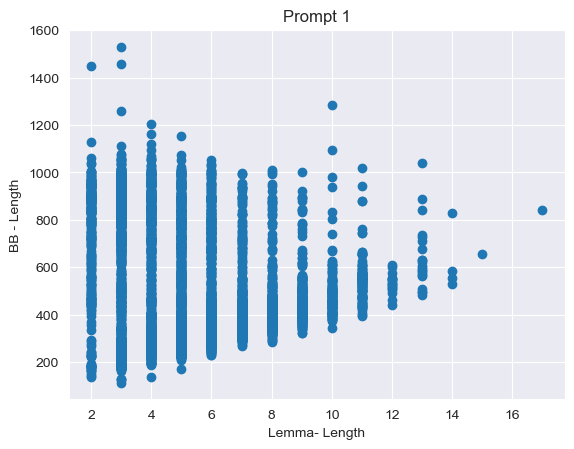

In [7]:
plt.scatter(data['length_lemma'], data['length'])
plt.title("Prompt 1")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Length")
plt.savefig("../../../graphics/2_BBs-OFA/LLength-Length_v1.jpg")

### LemmaLen x Height

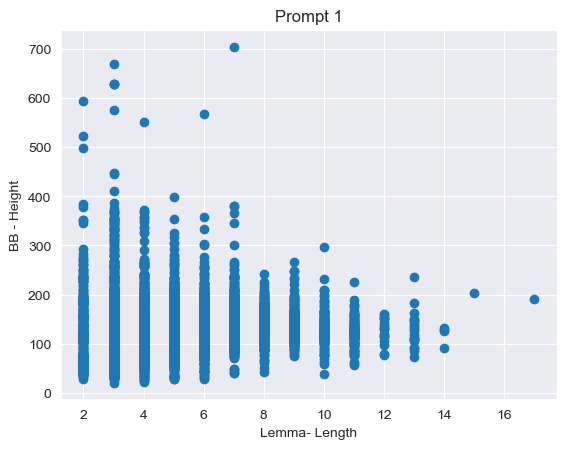

In [8]:
plt.scatter(data['length_lemma'], data['height'])
plt.title("Prompt 1")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Height")
plt.savefig("../../../graphics/2_BBs-OFA/LLength-Height_v1.jpg")

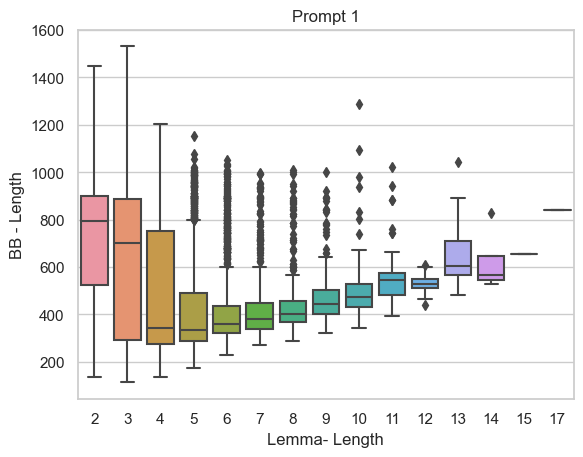

In [53]:
sns.set(style='whitegrid')
data_v = data.copy()
data_v["length_lemma"] = data_v["length_lemma"].astype("str")
length_lemma = list(map(str,data.groupby(["length_lemma"])["length"].mean().index.to_list()))
sns.boxplot(data = data_v, x = "length_lemma", y = "length", order=length_lemma).set_title("Prompt 1")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Length")
plt.savefig('../../../graphics/2_BBs-OFA/BP-Length_v1.png')

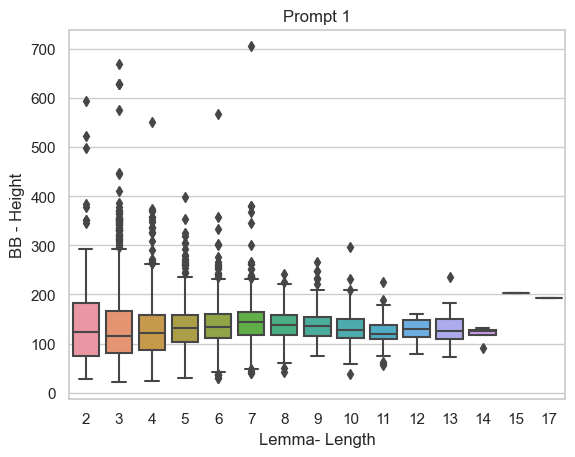

In [54]:
sns.set(style='whitegrid')
length_lemma = list(map(str,data.groupby(["length_lemma"])["length"].mean().index.to_list()))
sns.boxplot(data=data_v, x="length_lemma", y="height", order=length_lemma).set_title("Prompt 1")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Height")
plt.savefig('../../../graphics/2_BBs-OFA/BP-Height_v1.png')

In [ ]:
def image_with_bb(index):
image = Image.open(os.path.join(path2zettel, str(data.iloc[777]["id"])+".jpg"), mode="r")
x1 = data.iloc[115]["x1"]
y1 = data.iloc[777]["y1"]
x2 = data.iloc[777]["x2"]
y2 = data.iloc[777]["y2"]
img = ImageDraw.Draw(image)
img.rectangle([(x1,y1),(x2,y2)], outline ="green")

from IPython import display
display.display(image)

In [ ]:
# Calculating max and min of length per length_lemma
summary_length = data.groupby(["length_lemma"])["length"].mean().reset_index()
summary_length["q1"] = data.groupby(["length_lemma"])["length"].quantile(0.25).reset_index()["length"]
summary_length["q3"] = data.groupby(["length_lemma"])["length"].quantile(0.75).reset_index()["length"]
summary_length["IQR"] = summary_length["q3"] - summary_length["q1"]
summary_length["min_length"] = summary_length["q1"] - 1.5*summary_length["IQR"]
summary_length["max_length"] = summary_length["q3"] + 1.5*summary_length["IQR"]
summary_length.drop(["length", "q1","q3","IQR"], axis=1, inplace=True)

# Calculating max and min of height per length_lemma
summary_height = data.groupby(["length_lemma"])["height"].mean().reset_index()
summary_height["q1"] = data.groupby(["length_lemma"])["height"].quantile(0.25).reset_index()["height"]
summary_height["q3"] = data.groupby(["length_lemma"])["height"].quantile(0.75).reset_index()["height"]
summary_height["IQR"] = summary_height["q3"] - summary_height["q1"]
summary_height["min_height"] = summary_height["q1"] - 1.5*summary_height["IQR"]
summary_height["max_height"] = summary_height["q3"] + 1.5*summary_height["IQR"]
summary_height.drop(["height", "q1","q3","IQR"], axis=1, inplace=True)

# Merging values in the main data
data = data.merge(summary_length, how= "right", on= "length_lemma")
data = data.merge(summary_height, how= "right", on= "length_lemma")

# Calculating outliers
data["outliers_length"] = np.where(((data["length"]<data["min_length"]) | (data["length"]>data["max_length"])), "yes" , "no")
data["outliers_height"] = np.where(((data["height"]<data["min_height"]) | (data["height"]>data["max_height"])), "yes" , "no")

In [26]:
# Getting the outliers
def get_outliers(data, column:str) -> pd.DataFrame:
    q1 = data[column].quantile(0.25)
    q3= data[column].quantile(0.75)
    IQR = q3 - q1
    data["outliers"+"_"+column] = ["yes" if ((d<(q1-1.5*IQR)) | (d>(q3+1.5*IQR))) else "no" for d in data[column]]
    return data

get_outliers(data, "length")
get_outliers(data,"height")

id                  x1                  y1                  x2  \
0     213894  215.04502868652344   69.72772979736328   597.3473510742188   
1     210622   51.95195007324219  13.323323249816895   344.6146240234375   
2     198359  104.78077697753906  31.985984802246094   431.1471252441406   
3      37639  17.137136459350586  13.070070266723633   385.5856018066406   
6     218734   106.1851806640625   3.675675630569458   823.3703002929688   
...      ...                 ...                 ...                 ...   
5993  232995  201.67567443847656   84.71470642089844   599.8558959960938   
5994   47344   149.0930938720703    92.9909896850586   933.9739379882812   
5995  207390   163.3473358154297   80.81581115722656     444.86083984375   
5997  210113      159.9599609375   72.17417907714844  491.79180908203125   
5998   96330   115.2212142944336   49.57757568359375   452.2862548828125   

                      y2      length      height outliers_length  \
0       201.969970703125  382.302322  132.242241              no   
1     122.33232879638672  292.662674  109.009006              no   
2     190.68568420410156  326.366348  158.699699              no   
3     194.86285400390625  368.448465  181.792784              no   
6      172.7567596435547  717.185120  169.081084              no   
...                  ...         ...         ...             ...   
5993   220.2582550048828  398.180222  135.543549              no   
5994   189.5585479736328  784.880844   96.567558              no   
5995  202.64263916015625  281.513504  121.826828              no   
5997   183.3933868408203  331.831848  111.219208              no   
5998  181.38137817382812  337.065041  131.803802              no   

     outliers_height  
0                 no  
1                 no  
2                 no  
3                 no  
6                 no  
...              ...  
5993              no  
5994              no  
5995              no  
5997              no  
5998              no  

[5456 rows x 9 columns]

(array([180., 112.,  74., 107., 224., 128.,   1.,   1.,   2.,  40.]),
 array([ 113.23723221,  276.41350899,  439.58978577,  602.76606255,
         765.94233932,  929.1186161 , 1092.29489288, 1255.47116966,
        1418.64744644, 1581.82372322, 1745.        ]),
 <BarContainer object of 10 artists>)

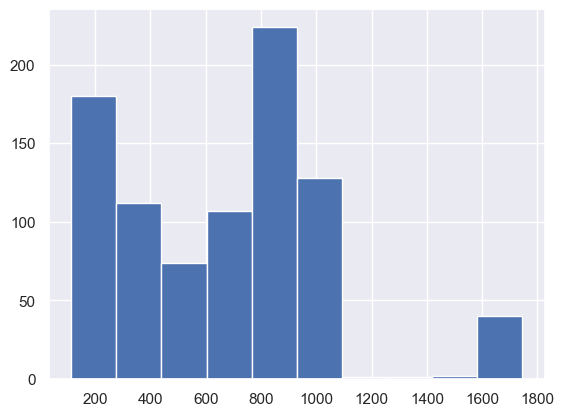

In [65]:
len3= total_data[total_data['length_lemma']==3]
plt.hist(len3["length"])

In [30]:
total_data[total_data["lemma"]=="ut"]

id lemma  length_lemma                  x1                  y1  \
3411  217560    ut             2  156.76776123046875   92.28028106689453   
3412  217586    ut             2  161.33033752441406   74.55555725097656   
3413  217606    ut             2  169.04605102539062   73.82282257080078   
3414  217620    ut             2  150.92193603515625    81.2852783203125   
3415  217634    ut             2  150.22523498535156    91.9759750366211   
...      ...   ...           ...                 ...                 ...   
3904  226950    ut             2  110.52851867675781   72.29629516601562   
3905  226974    ut             2  100.20820617675781    86.9189224243164   
3906  226984    ut             2  178.67868041992188  222.86485290527344   
3907  227006    ut             2   77.74774932861328    49.0850830078125   
3908  227029    ut             2      72.06005859375  122.02902221679688   

                      x2                  y2      length      height  \
3411   778.6707153320312   310.8388366699219  621.902954  218.558556   
3412   393.7847900390625   183.3333282470703  232.454453  108.777771   
3413        331.12109375  187.58258056640625  162.075043  113.759758   
3414    333.069091796875     203.81982421875  182.147156  122.534546   
3415   1034.309326171875   309.8138122558594  884.084091  217.837837   
...                  ...                 ...         ...         ...   
3904    870.830810546875  188.44442749023438  760.302292  116.148132   
3905   817.2152099609375  196.77476501464844  717.007004  109.855843   
3906  1031.2313232421875   377.3373107910156  852.552643  154.472458   
3907  1047.0030517578125   240.6366424560547  969.255302  191.551559   
3908   988.2522583007812  196.93792724609375  916.192200   74.908905   

     outliers_length outliers_height  
3411              no              no  
3412              no              no  
3413              no              no  
3414              no              no  
3415              no              no  
...              ...             ...  
3904              no              no  
3905              no              no  
3906              no              no  
3907              no              no  
3908              no              no  

[161 rows x 11 columns]

In [19]:
outliers = total_data[(total_data["outliers_height"]=="yes") & (total_data["outliers_length"]=="no")]
outliers.reset_index(drop=True,inplace=True)

In [23]:
outliers

id    lemma  length_lemma                  x1                  y1  \
0     13596    salus             5    91.9459457397461  170.78079223632812   
1     14286  sanctus             7                 0.0                 0.0   
2     18891    satis             5   131.0030059814453   91.36737060546875   
3     19589     scio             4   158.2252197265625    94.1061019897461   
4     19611     scio             4  156.22122192382812   129.5135040283203   
..      ...      ...           ...                 ...                 ...   
165  307317      non             3  159.93392944335938     124.85986328125   
166  307539      non             3  150.22523498535156    97.1351318359375   
167  307539      non             3  150.22523498535156    97.1351318359375   
168  307542      non             3   99.80179595947266   98.02702331542969   
169  307687      non             3   155.9479522705078     98.270263671875   

                     x2                  y2      length      height  \
0     921.1621704101562   476.0060119628906  829.216225  305.225220   
1    397.60760498046875  250.92791748046875  397.607605  250.927917   
2    1044.5765380859375   490.4985046386719  913.573532  399.131134   
3    1053.6756591796875   442.0510559082031  895.450439  347.944954   
4    1038.6136474609375   466.4884948730469  882.392426  336.974991   
..                  ...                 ...         ...         ...   
165    668.970947265625   412.9029235839844  509.037018  288.043060   
166  391.96697998046875  356.16217041015625  241.741745  259.027039   
167  391.96697998046875  356.16217041015625  241.741745  259.027039   
168  1042.7567138671875  451.40838623046875  942.954918  353.381363   
169      872.2802734375   433.1170959472656  716.332321  334.846832   

    outliers_length outliers_height  
0                no             yes  
1                no             yes  
2                no             yes  
3                no             yes  
4                no             yes  
..              ...             ...  
165              no             yes  
166              no             yes  
167              no             yes  
168              no             yes  
169              no             yes  

[170 rows x 11 columns]

In [20]:
path_images= "Z:/MLW/zettel/"
files = [d for d in outliers["id"]]
# images = [Image.open(os.path.join(path_images, i+".jpg"), mode="r") for i in files]
# outliers["images"] = images

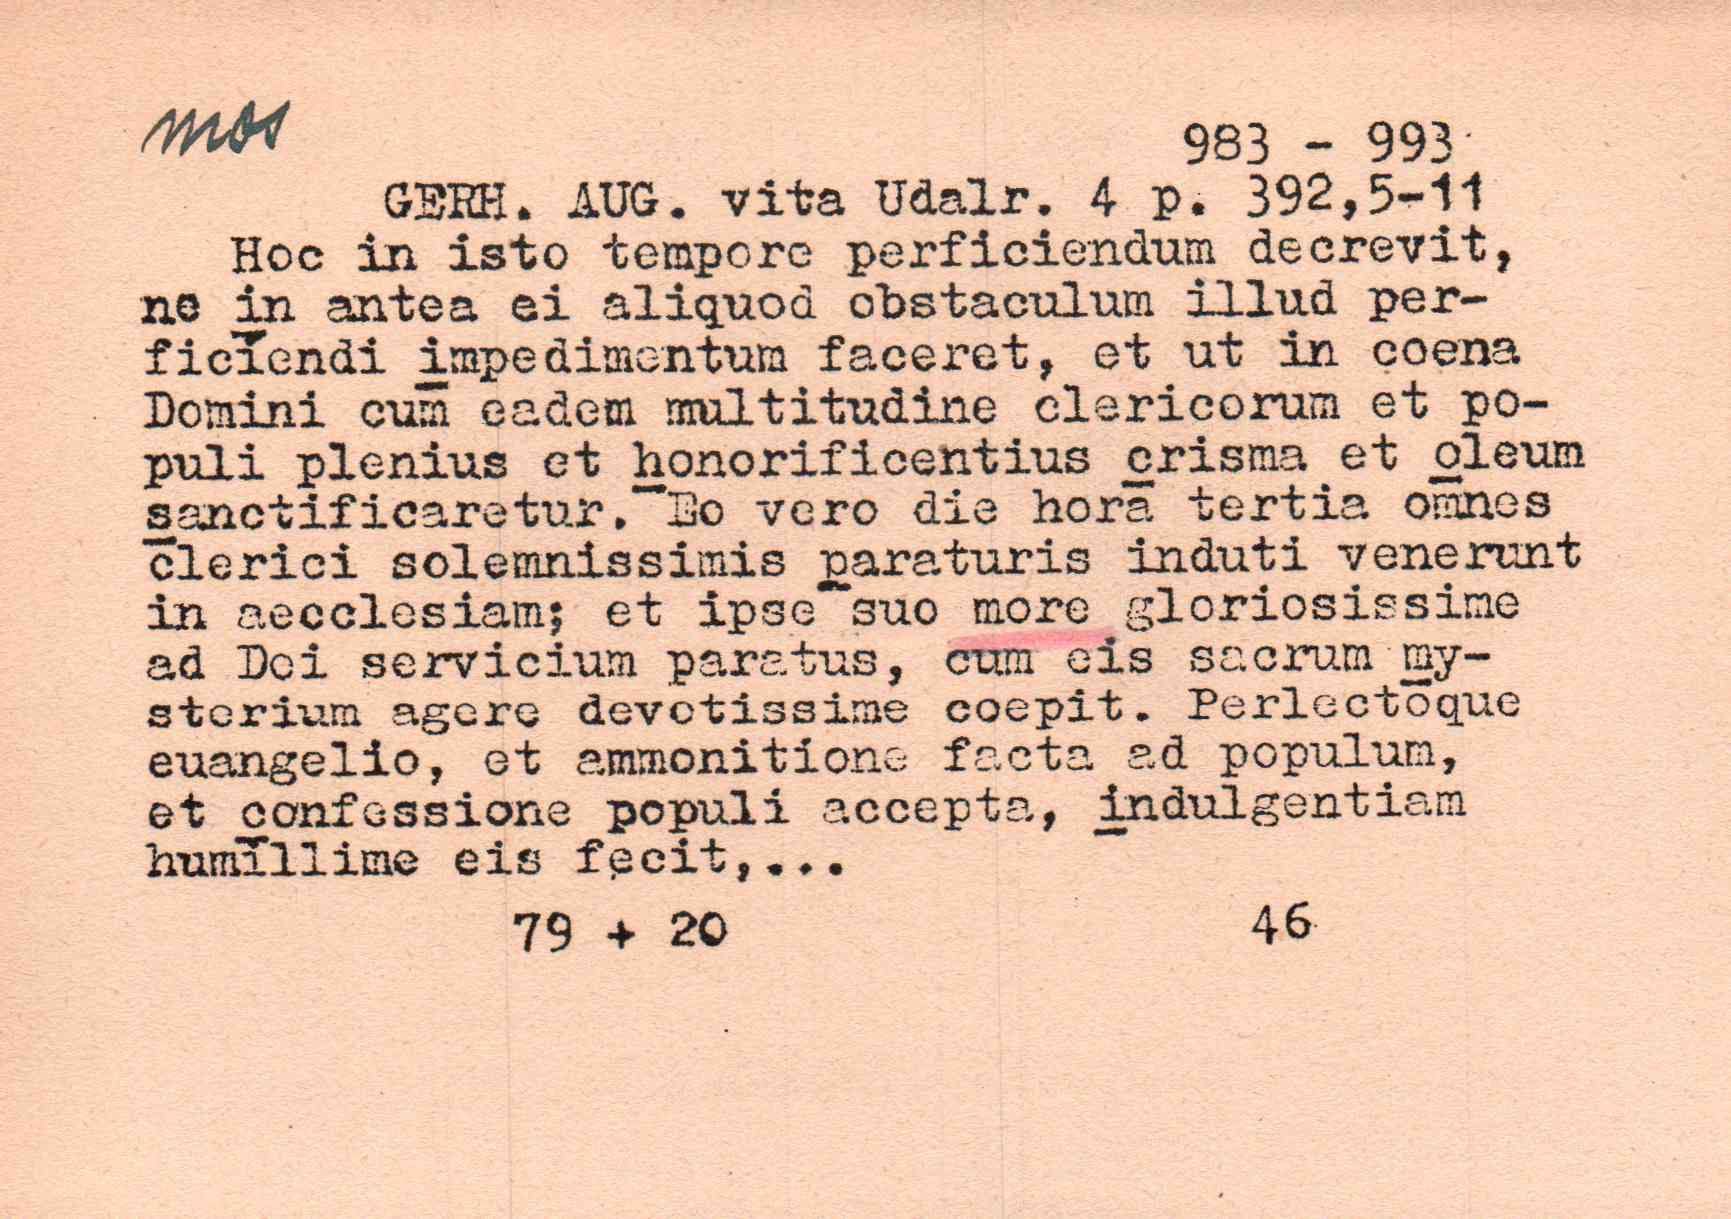

In [24]:
[cv2.rectangle(i, pt1 = (outliers["x1"].astype("float"), ), pt2= (), color = (255, 0, 0), thickness= 3) for i in outliers["images"]]

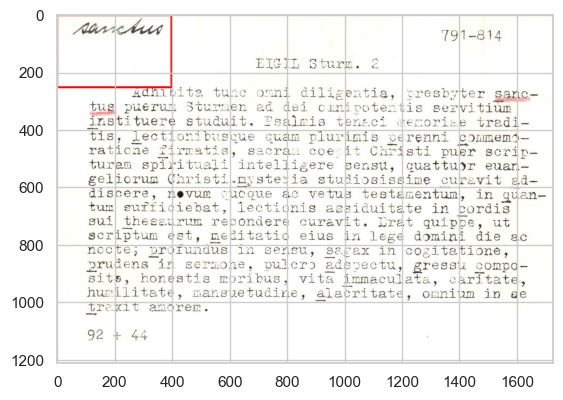

In [21]:
prueba = cv2.imread(os.path.join(path_images, str(outliers["id"][1])+".jpg"))
prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)
x1 = round(float(outliers["x1"][1]))
y1 = round(float(outliers["y1"][1]))
x2 = round(float(outliers["x2"][1]))
y2 = round(float(outliers["y2"][1]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)

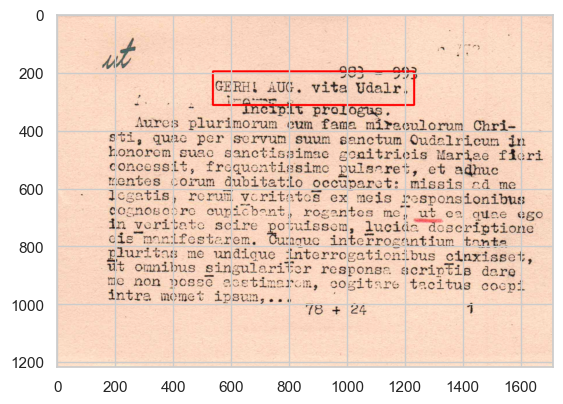

In [29]:
prueba = cv2.imread(os.path.join(path_images, str(total_data["id"][3453])+".jpg"))
prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)
x1 = round(float(total_data["x1"][3453]))
y1 = round(float(total_data["y1"][3453]))
x2 = round(float(total_data["x2"][3453]))
y2 = round(float(total_data["y2"][3453]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)

In [28]:
prueba_2 = Image.open(os.path.join(path_images, str(total_data["id"][3419])+".jpg"), mode="r")
img = ImageDraw.Draw(prueba_2)
img.rectangle([(x1,y1),(x2,y2)], outline ="green")
prueba_2.show()

In [84]:
total_data[total_data["lemma"]=="mos"]

id lemma  length_lemma                  x1                  y1  \
5349  295347   mos             3   105.6356430053711   87.63964080810547   
5350  295362   mos             3   51.80180358886719  43.567569732666016   
5351  295366   mos             3  149.00601196289062  170.21621704101562   
5352  295373   mos             3  160.58558654785156    194.270263671875   
5353  295378   mos             3   141.2432403564453  102.07807922363281   
5354  295423   mos             3   200.9969940185547   89.33333587646484   
5355  295425   mos             3   159.6546630859375   99.23722839355469   
5356  295437   mos             3  100.49849700927734  100.05805206298828   
5357  295443   mos             3  131.03103637695312  112.91291809082031   
5358  295450   mos             3   122.8108139038086   87.20720672607422   
5427  296672   mos             3  118.59158325195312   92.66065979003906   
5428  296689   mos             3   156.3123016357422   94.79078674316406   
5429  296696   mos             3  185.62161254882812  152.21621704101562   
5430  296709   mos             3  157.67868041992188   89.22222137451172   
5431  296754   mos             3   387.3333435058594   160.9369354248047   
5432  296780   mos             3   51.53152847290039   196.1221160888672   
5433  296810   mos             3    67.0690689086914   268.6686706542969   
5434  296819   mos             3   387.3333435058594  224.33633422851562   
5435  296822   mos             3  131.30731201171875     100.14013671875   
5436  296860   mos             3                 0.0    159.929931640625   
5437  296868   mos             3   92.97296905517578   92.05204772949219   
5438  296922   mos             3   58.47046661376953                 0.0   
5439  296924   mos             3                 0.0                 0.0   
5440  296927   mos             3   51.44144058227539    98.9909896850586   

                      x2                  y2       length       height  \
5349      1009.599609375  187.45144653320312   903.963966    99.811806   
5350    259.009033203125  117.39038848876953   207.207230    73.822819   
5351   933.4284057617188     284.90087890625   784.422394   114.684662   
5352   1151.726806640625  248.23423767089844   991.141220    53.963974   
5353   613.7977905273438   286.7908020019531   472.554550   184.712723   
5354     405.45947265625  154.52252197265625   204.462479    65.189186   
5355   829.1741943359375   309.8138122558594   669.519531   210.576584   
5356  1050.0360107421875   455.1421203613281   949.537514   355.084068   
5357    1099.29931640625   258.7587585449219   968.268280   145.845840   
5358   339.4354248046875   163.5135040283203   216.624611    76.306297   
5427  1148.1041259765625  157.27928161621094  1029.512543    64.618622   
5428  1018.6065673828125   310.5645751953125   862.294266   215.773788   
5429  1041.5435791015625  304.43243408203125   855.921967   152.216217   
5430   881.9609985351562   199.2222137451172   724.282318   109.999992   
5431   875.8618774414062  235.30931091308594   488.528534    74.372375   
5432  1087.3153076171875  239.43743896484375  1035.783779    43.315323   
5433   1042.150146484375   321.1811828613281   975.081078    52.512512   
5434   902.0330200195312   274.3243103027344   514.699677    49.987976   
5435    941.611572265625  288.20819091796875   810.304260   188.068054   
5436   877.8848876953125   314.9389343261719   877.884888   155.009003   
5437   938.3383178710938  170.78079223632812   845.365349    78.728745   
5438   326.7467346191406  158.40640258789062   268.276268   158.406403   
5439              1732.0              1207.0  1732.000000  1207.000000   
5440        1039.1171875  181.08108520507812   987.675747    82.090096   

     outliers_length outliers_height  
5349              no              no  
5350              no              no  
5351              no              no  
5352              no              no  
5353              no              no  
5354              no    

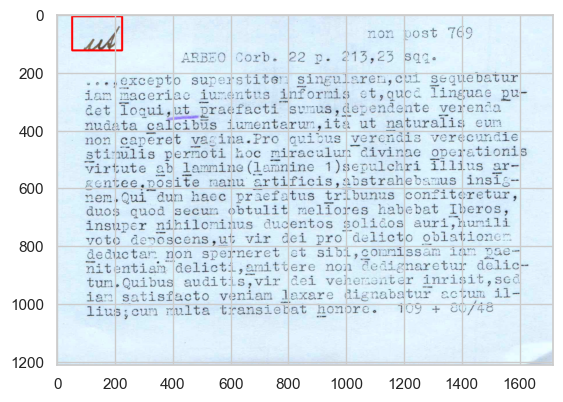

In [25]:
prueba = cv2.imread(os.path.join(path_images, str(total_data["id"][3419])+".jpg"))
x1 = round(float(total_data["x1"][3419]))
y1 = round(float(total_data["y1"][3419]))
x2 = round(float(total_data["x2"][3419]))
y2 = round(float(total_data["y2"][3419]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)